# Validação Cruzada com Naive Bayes

In [1]:
# Importações
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

from mpl_toolkits.mplot3d import Axes3D

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

import random
random.seed(42)

## 1) Leitura da Base

In [2]:
# Bases a serem utilizadas - 
# 'df_final_20200510.csv' - 'df_kbest_fclassif_20200510.csv' - 'df_pca_features_importances_20200510.csv'
# 'df_random_forest_importances_20200510.csv' - 'df_RFE_20200510.csv' - 'df_SBS_20200510.csv' - 'df_SFS_20200510.csv'

df = pd.read_csv('df_final_20200510.csv')

print("Número de linhas e colunas:", df.shape, '\n')
print('\n', df.info(), '\n')

df.head()

Número de linhas e colunas: (217, 329) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Columns: 329 entries, idade to TARGET
dtypes: float64(321), int64(8)
memory usage: 557.9 KB

 None 



,idade,sexo,volume,massa,EDLEndo01,EDLEndo02,EDLEndo03,EDLEndo04,EDLEndo05,EDLEndo06,...,TotalParedeSpharmL02,TotalParedeSpharmL03,TotalParedeSpharmL04,TotalParedeSpharmL05,TotalParedeSpharmL06,TotalParedeSpharmL07,TotalParedeSpharmL08,TotalParedeSpharmL09,TotalParedeSpharmL10,TARGET
0,29,1,74,110,0.0,0.0,21.6,0.0,15.9,0.0,...,335894.282142,86542.210472,62266.013014,7802.051260,1.065069e+06,573021.021046,-2.025431e+05,-9.524011e+05,-2.381297e+06,0
1,31,1,94,126,16.1,0.0,133.0,0.0,0.0,0.0,...,23698.701494,22189.016025,4403.174271,40612.513318,4.383326e+04,81818.458232,4.615117e+04,4.650854e+04,3.576759e+04,0
2,27,1,92,157,33.4,0.0,84.4,0.0,0.0,0.0,...,-705382.958037,-151282.146856,67138.663165,-8005.459046,-4.585848e+05,-741606.061804,-1.107879e+07,3.488353e+06,8.794934e+06,0
3,52,1,106,107,0.0,0.0,17.4,0.0,0.0,0.0,...,46566.673586,-48469.232119,36230.421882,41169.985242,-1.000896e+03,-79029.758729,-2.013094e+04,-1.488101e+04,-4.085351e+04,0
4,56,1,68,73,2.7,0.0,115.0,0.0,0.0,0.0,...,4503.168069,-20060.300707,40453.585284,572.456509,1.549634e+04,13154.569224,1.391572e+04,1.513852e+04,-3.441970e+03,0


## 2) Preparação do dataset

In [3]:
# Preparação e separação da base para as demais atividades
dfx = df.copy()
dfx.reset_index(inplace=True, drop=True)

# Armazenando as classes
classes = dfx['TARGET'].value_counts()
attributes = list(df.columns)

# Guardando a coluna Target em Y e removendo a coluna TARGET da base principal
Y = dfx.loc[:, 'TARGET']
dfx = dfx.drop('TARGET', axis=1)

# Guardando a quantidade de linhas e colunas após a separação da coluna TARGET
nrow, ncol = dfx.shape

# Armazenando as colunas (atributos)
attributes = list(dfx.columns)

# Transformando para numpy
X = dfx.to_numpy()

# Normalizando
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

dfx.head()

,idade,sexo,volume,massa,EDLEndo01,EDLEndo02,EDLEndo03,EDLEndo04,EDLEndo05,EDLEndo06,...,TotalParedeSpharmL01,TotalParedeSpharmL02,TotalParedeSpharmL03,TotalParedeSpharmL04,TotalParedeSpharmL05,TotalParedeSpharmL06,TotalParedeSpharmL07,TotalParedeSpharmL08,TotalParedeSpharmL09,TotalParedeSpharmL10
0,29,1,74,110,0.0,0.0,21.6,0.0,15.9,0.0,...,-370009.497215,335894.282142,86542.210472,62266.013014,7802.051260,1.065069e+06,573021.021046,-2.025431e+05,-9.524011e+05,-2.381297e+06
1,31,1,94,126,16.1,0.0,133.0,0.0,0.0,0.0,...,-141806.576054,23698.701494,22189.016025,4403.174271,40612.513318,4.383326e+04,81818.458232,4.615117e+04,4.650854e+04,3.576759e+04
2,27,1,92,157,33.4,0.0,84.4,0.0,0.0,0.0,...,-570967.303337,-705382.958037,-151282.146856,67138.663165,-8005.459046,-4.585848e+05,-741606.061804,-1.107879e+07,3.488353e+06,8.794934e+06
3,52,1,106,107,0.0,0.0,17.4,0.0,0.0,0.0,...,-139380.800912,46566.673586,-48469.232119,36230.421882,41169.985242,-1.000896e+03,-79029.758729,-2.013094e+04,-1.488101e+04,-4.085351e+04
4,56,1,68,73,2.7,0.0,115.0,0.0,0.0,0.0,...,-95503.576892,4503.168069,-20060.300707,40453.585284,572.456509,1.549634e+04,13154.569224,1.391572e+04,1.513852e+04,-3.441970e+03


## 3) Partição do dataset em k folds
<br> Como o dataset completo possui 217 linhas e 329 colunas, optamos em utilizar o SVD no lugar do PCA com 
dois componentes, já que no SVD não é possível trabalhar com todos os componentes.</br>

In [4]:
############################################################
#### Função de separação de uma base em k sub-conjuntos ####
#### Recebe:                                            ####
#### -- data: dataframe dos atributos                   ####
#### -- target: array com a coluna alvo                 ####
#### -- k: quantidade desejada de separação             ####
####                                                    ####
#### Retorna:                                           ####
#### -- Os índices a serem considerados em cada parte   ####
############################################################
def splitFolds(data, target, k=10):
    
    # Contadores para apresentação
    ldata = len(data)              # Quantidade de linhas da base
    numel = int(ldata / k)         # Quantidade de amostras por fold
        
    uclass = target.value_counts() # Classes e suas quantidades
    uclass.sort_index(inplace=True)
    nclass = uclass.index          # Classes
    qclass = uclass.values         # Quantidade de cada classe
    
    # Junção das classes e suas quantidades para um dicionário
    zclass = zip(nclass, qclass)   
    dclass = dict(zclass)          
    
    # Separação dos conjuntos
    partesK = []    # Conterá todos os conjuntos k de índices, cada um proporcional a cada classe
    for i in range(k):
        pk = []
        if (i < 7):
            nelem = numel + 1
        else:
            nelem = numel
            
        ntot = nelem
        
        for nc, qc in dclass.items():
            # Captura de todos os índices da coluna target
            masc = target == nc
            idclass = list(target[masc].index)
        
            # Montagem dos k subgrupos com a mesma proporção da classe
            propclass = int(round(nelem * qc / ldata))
            if (ntot > propclass):
                ntot -= propclass
            else:
                propclass = ntot
            
            rs = random.sample(idclass, propclass)
            pk = pk + rs
            
        partesK.append(pk)
        
    return (partesK)          


In [5]:
# Separação do dataset
k = 10
partesK = splitFolds(X, Y, k)

# Estatísticas da separação
qtdDS = len(X)
vc = Y.value_counts()
qtdT0 = vc.values[1]
qtdT2 = vc.values[0]
perT0 = round(qtdT0/qtdDS * 100, 2)
perT2 = round(qtdT2/qtdDS * 100, 2)

print('**** Dataset: CMCT_20200503.csv ****')
print('K =', k, '- Dataset:', qtdT0, 'SAN e', qtdT2, 'CMD (', perT0, '%  x ', perT2, '% )')
print()

qtd0 = 0
qtd2 = 0
per0 = 0.0
per2 = 0.0

for f in range(len(partesK)):
    dx = Y[partesK[f]]
    vc = dx.value_counts()
    qtd0 = vc.values[1]
    qtd2 = vc.values[0]
    per0 = round(qtd0/(qtd0 + qtd2) * 100, 2)
    per2 = round(qtd2/(qtd0 + qtd2) * 100, 2)
    
    print(f'Fold {f+1}: SAN: {qtd0}, CMD: {qtd2}, Total: {qtd0+qtd2}, Proporção: {per0}%; {per2}%)')

**** Dataset: CMCT_20200503.csv ****
K = 10 - Dataset: 101 SAN e 116 CMD ( 46.54 %  x  53.46 % )

Fold 1: SAN: 10, CMD: 12, Total: 22, Proporção: 45.45%; 54.55%)
Fold 2: SAN: 10, CMD: 12, Total: 22, Proporção: 45.45%; 54.55%)
Fold 3: SAN: 10, CMD: 12, Total: 22, Proporção: 45.45%; 54.55%)
Fold 4: SAN: 10, CMD: 12, Total: 22, Proporção: 45.45%; 54.55%)
Fold 5: SAN: 10, CMD: 12, Total: 22, Proporção: 45.45%; 54.55%)
Fold 6: SAN: 10, CMD: 12, Total: 22, Proporção: 45.45%; 54.55%)
Fold 7: SAN: 10, CMD: 12, Total: 22, Proporção: 45.45%; 54.55%)
Fold 8: SAN: 10, CMD: 11, Total: 21, Proporção: 47.62%; 52.38%)
Fold 9: SAN: 10, CMD: 11, Total: 21, Proporção: 47.62%; 52.38%)
Fold 10: SAN: 10, CMD: 11, Total: 21, Proporção: 47.62%; 52.38%)


## 4) Aplicação do Naive Bayes - Bernouilli

In [72]:
qtdRodada = len(partesK)
vauc = []
vacc = []

# Hiperparâmetro para treinamento
alpha = [0.1, 0.5, 1.0]

# Dicionário que irá armazenar, para cada rodada (k folds) a acurácia e a roc.
avalia = {}  # padrão avalia={alpha:{fold de teste(r):{n:[qt classe 0, qt classe 2], roc:[], mat:[]}}}

# Laço de repetição para todos alphas
for al in alpha:
    avalia[al] = {}
    # Laço de repetição para quantidade de folds
    for r in range(qtdRodada):
        avalia[al][r] = {'nc':[], 'acu':[], 'roc':[], 'mat':[]}
    
        # Montagem da parte de Teste e da parte de treino
        iTreino = []
        iTeste = []
        for i, p in enumerate(partesK):
            if (i == r):
                # Fold das partesK que será utilizada para o teste
                iTeste = p
                continue
        
            # Montando os demais folds para Treinamento
            for a in p:
                iTreino.append(a)
        
        # Organiza os indices a serem considerados
        iTreino.sort()
        iTeste.sort()
    
        # Aplicando o modelo
        x_train, x_test = X[iTreino], X[iTeste]
        y_train, y_test = Y[iTreino], Y[iTeste]
        
        # Treinando e aplicando o modelo NB na base inteira
        modelGNB = BernoulliNB(alpha = al)
        modelGNB.fit(x_train, y_train)
        y_pred = modelGNB.predict(x_test)
    
        # Guardando as quantidade de amostras por classe
        v, c = np.unique(y_pred, return_counts=True)
        avalia[al][r]['nc'] = c
            
        # Calculando os resultados da curva roc (vauc) e acurácia (vacc)
        avalia[al][r]['roc'].append(roc_auc_score(y_test, y_pred))
        avalia[al][r]['acu'].append(accuracy_score(y_pred, y_test))
        avalia[al][r]['mat'].append(list(confusion_matrix(y_test, y_pred)))
    

In [73]:
# Dicionário de resultados
for k, v in avalia.items():
    print('\n\nalpha = ', k)
    for k1, v1 in v.items():
        print('\nFold de Teste = ', k1)
        for k2, v2 in v1.items():
            print(k2, v2)



alpha =  0.1

Fold de Teste =  0
nc [ 9 13]
acu [0.7727272727272727]
roc [0.7666666666666667]
mat [[array([7, 3], dtype=int64), array([ 2, 10], dtype=int64)]]

Fold de Teste =  1
nc [10 12]
acu [0.7272727272727273]
roc [0.7249999999999999]
mat [[array([7, 3], dtype=int64), array([3, 9], dtype=int64)]]

Fold de Teste =  2
nc [ 9 13]
acu [0.7727272727272727]
roc [0.7666666666666667]
mat [[array([7, 3], dtype=int64), array([ 2, 10], dtype=int64)]]

Fold de Teste =  3
nc [11 11]
acu [0.7727272727272727]
roc [0.7750000000000001]
mat [[array([8, 2], dtype=int64), array([3, 9], dtype=int64)]]

Fold de Teste =  4
nc [13  9]
acu [0.5909090909090909]
roc [0.5999999999999999]
mat [[array([7, 3], dtype=int64), array([6, 6], dtype=int64)]]

Fold de Teste =  5
nc [11 11]
acu [0.6818181818181818]
roc [0.6833333333333332]
mat [[array([7, 3], dtype=int64), array([4, 8], dtype=int64)]]

Fold de Teste =  6
nc [10 12]
acu [0.9090909090909091]
roc [0.9083333333333332]
mat [[array([9, 1], dtype=int64), ar

In [76]:
print(avalia[0.1][6]['nc'][0])

10


In [80]:
n = 0
# Matriz de confusão
for k, v in avalia.items():
    for k1, v1 in v.items():
        print('\n\n===> alpha = ', k, '==> Fold de Teste = ', k1)
        for k2, v2 in v1.items():
            if (k2 == 'nc'):
                n = v2[0] + v2[1]
                n0 = v2[0]
                n1 = v2[1]
            elif (k2 == 'acu'):
                print ('Acurácia:', v2[0])
            elif (k2 == 'roc'):
                print('Roc:', v2[0])
            else:
                vp = v2[0][0][0]
                vn = v2[0][0][1]
                fp = v2[0][1][0]
                fn = v2[0][1][1]
                print('=== Total de amostras de Teste:', n, 'Normal:', n0, 'Anormal:', n1)
                print('#### Matriz de Confusão ####')       
                print('VP:', vp, '\tVN:', vn)
                print('FN:', fn, '\tFP:', fp)
                print('############################')
                print('Acurácia ((VP + VN)/n):', (vp + vn)/n)
                print('Precisão (VP / (VP + FP)):', (vp / (vp + fp)))
                print('Revocação (VP / (VP + FN)):', (vp / (vp + fn)))
                      



===> alpha =  0.1 ==> Fold de Teste =  0
Acurácia: 0.7727272727272727
Roc: 0.7666666666666667
=== Total de amostras de Teste: 22 Normal: 9 Anormal: 13
#### Matriz de Confusão ####
VP: 7 	VN: 3
FN: 10 	FP: 2
############################
Acurácia ((VP + VN)/n): 0.45454545454545453
Precisão (VP / (VP + FP)): 0.7777777777777778
Revocação (VP / (VP + FN)): 0.4117647058823529


===> alpha =  0.1 ==> Fold de Teste =  1
Acurácia: 0.7272727272727273
Roc: 0.7249999999999999
=== Total de amostras de Teste: 22 Normal: 10 Anormal: 12
#### Matriz de Confusão ####
VP: 7 	VN: 3
FN: 9 	FP: 3
############################
Acurácia ((VP + VN)/n): 0.45454545454545453
Precisão (VP / (VP + FP)): 0.7
Revocação (VP / (VP + FN)): 0.4375


===> alpha =  0.1 ==> Fold de Teste =  2
Acurácia: 0.7727272727272727
Roc: 0.7666666666666667
=== Total de amostras de Teste: 22 Normal: 9 Anormal: 13
#### Matriz de Confusão ####
VP: 7 	VN: 3
FN: 10 	FP: 2
############################
Acurácia ((VP + VN)/n): 0.4545454545454

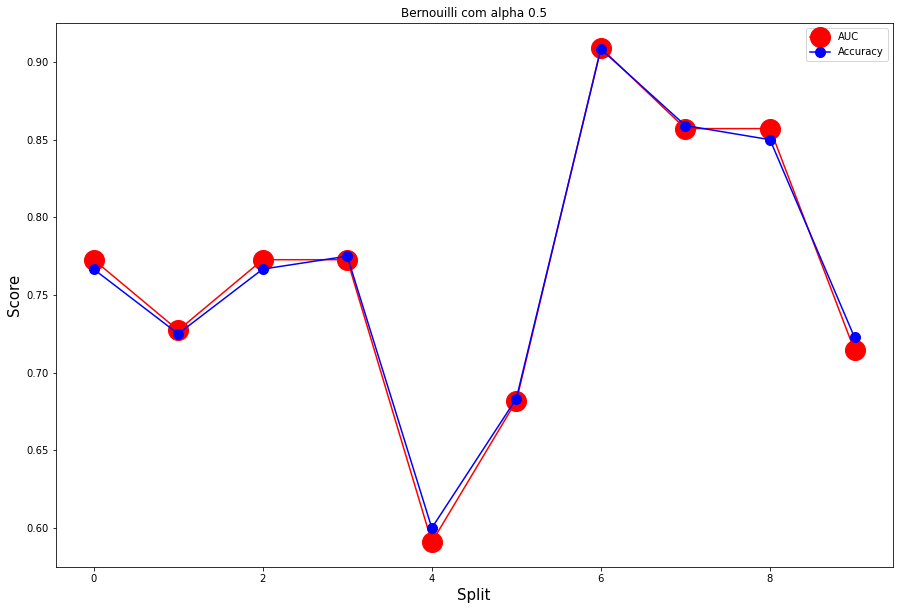

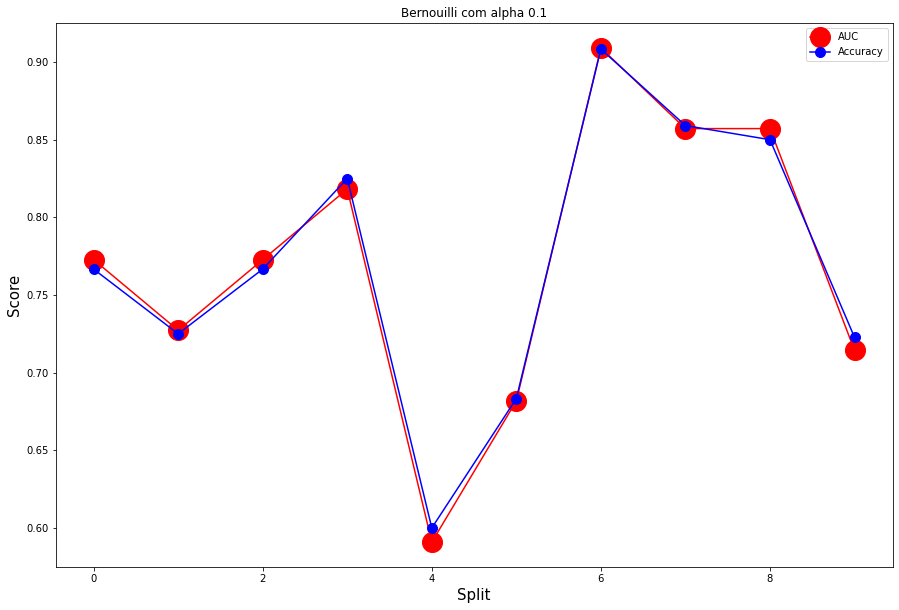

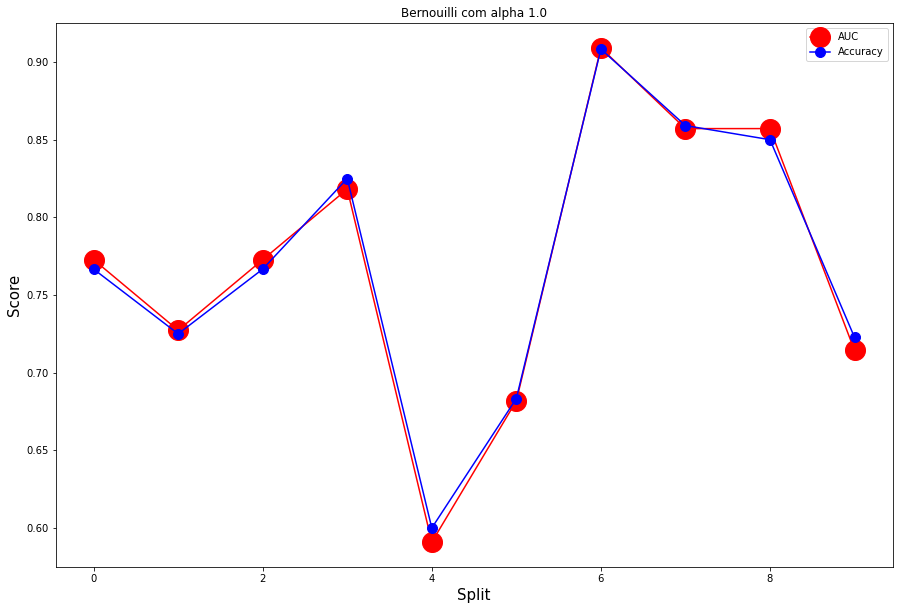

In [81]:
alpha = 0.1
vx = list(avalia[alpha].keys())
vya = [] 
vyr = []

for k, v in avalia[alpha].items():
    for k1, v1 in v.items():
        if k1 == 'acu':
            vya.append(v1)
        elif k1 == 'roc':
            vyr.append(v1)

# Gráfico de comparação
plt.figure(figsize=(15,10))
plt.title('Bernouilli com alpha 0.5')
plt.plot(vx, vya, '-ro', label= 'AUC', markersize=20)
plt.plot(vx, vyr, '-bo', label = 'Accuracy', markersize=10)
plt.legend()
plt.xlabel('Split', fontsize = 15)
plt.ylabel('Score', fontsize = 15)
plt.show()

alpha = 0.5
vx = list(avalia[alpha].keys())
vya = [] 
vyr = []

for k, v in avalia[alpha].items():
    for k1, v1 in v.items():
        if k1 == 'acu':
            vya.append(v1)
        elif k1 == 'roc':
            vyr.append(v1)

# Gráfico de comparação
plt.figure(figsize=(15,10))
plt.title('Bernouilli com alpha 0.1')
plt.plot(vx, vya, '-ro', label= 'AUC', markersize=20)
plt.plot(vx, vyr, '-bo', label = 'Accuracy', markersize=10)
plt.legend()
plt.xlabel('Split', fontsize = 15)
plt.ylabel('Score', fontsize = 15)
plt.show()


alpha = 1.0
vx = list(avalia[alpha].keys())
vya = [] 
vyr = []

for k, v in avalia[alpha].items():
    for k1, v1 in v.items():
        if k1 == 'acu':
            vya.append(v1)
        elif k1 == 'roc':
            vyr.append(v1)

# Gráfico de comparação
plt.figure(figsize=(15,10))
plt.title('Bernouilli com alpha 1.0')
plt.plot(vx, vya, '-ro', label= 'AUC', markersize=20)
plt.plot(vx, vyr, '-bo', label = 'Accuracy', markersize=10)
plt.legend()
plt.xlabel('Split', fontsize = 15)
plt.ylabel('Score', fontsize = 15)
plt.show()


